In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

## Open AI gym

Open AI gym is a standard reinforcement learning environment to train models.

In [2]:
if gym.__version__[:4] == '0.26':
    env = gym.make('CartPole-v1')
elif gym.__version__[:4] == '0.25':
    env = gym.make('CartPole-v1', new_step_api=True)
else:
    raise ImportError(f"Requires gym v25 or v26, actual version: {gym.__version__}")

In [3]:
gym.__version__

'0.26.2'

In [4]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
device

device(type='cuda')

## Data collection

The ReplayMemory class will hold the transitions of states, actions, next states, and rewards between states.

In [6]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
        
    def push(self, *args):
        self.memory.append(Transition(*args))
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

# DQN Algorithm

# $$ R_{t_0} = \sum_{t=t_0}^\infty \gamma^{t-t_0} r_t$$ 

Our model will try to maximize this function, finding the largest possible discounted cumulative reward

$ R_{t_0}$ is known as the **return**. $\gamma$ is the **discount** factor and $r_t$ is the state **reward**.

This function uses $\gamma$ to calculate the discount of future rewards. This discount allows immediate rewards to have greater effects than rewards further into the future.

As we have no function to determine the approximate rewards of every action, we will use a neural network to iteratively approximate the expected rewards of actions.

This equation denotes the policy that finds the highest valued action for a given state/action pair

## $$ \pi^*(s) = \underset{a}{argmax} \ Q^*(s,a)$$

This is the training update rule that will update  $Q^\pi$, based on it's state/action pair reward and the discounted next state/action rewards. Known as the bellman equation.

## $$ Q^\pi (s,a) = r + \gamma Q^\pi(s', \pi(s'))$$

This is the error function, Temporal Difference Error, used to measure how accurate the current Q function is. 

## $$ \delta =  Q^\pi (s,a) - (r + \gamma \ \overset{'}{\underset{a}{max}} \ Q^\pi(s', \pi(s'))$$

This function will minismise the loss using Huber loss. Similar to mean squared error when the error is small, but similar to mean absolute error when error is large. This makes it more robust, as it can handle outliers when Q estimates are noisy.

## $ \cal L = \frac{1}{|B|} \sum_{(s,a,s',r)\epsilon B} \cal L(\delta)$

where $ \cal L(\delta) = \begin{cases} \frac{1}{2} \delta^2 \ \ \ \ \ \ \ \ \ \textrm{for} |\delta| <= 1 \\ |\delta| - \frac{1}{2} \ \ \ \textrm{ otherwise} \end{cases} $

In [7]:
class DQN(nn.Module):
    
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)        
        self.layer3 = nn.Linear(128, n_actions)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))  
        return self.layer3(x)

This neural network will output the action to take in a given state. During training, it will effectively be trying to determine the Q value of each state action pair.

In [8]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

n_actions = env.action_space.n

if gym.__version__[:4] == '0.26':
    state, _ = env.reset()
elif gym.__version__[:4] == '0.25':
    state, _ = env.reset(return_info=True)
    
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

Using a epsilon greedy algorithm, our policy will at times randomly choose an action to take to aid in exploration and avoid over-exploitation, with the number of random choices decaying over time.

In [9]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1,1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
    
episode_durations = []

This function will plot the durations of the episodes as they occur.

In [10]:
def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    
    if len(durations_t) >= 100:
        means = durations_t.unfold(0,100,1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
        
    plt.pause(0.001)
    
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

## Optimization

This function will only start optimizing the model after it has at least a batch of transitions, in this case, 128 timesteps.

Once it has enough transitions, it will randomly sample these transition states and calculate the values of each action as a batch, for each given batch of states. 

It will then use the secondary target network to compute the values of the batch of next states, and use the bellman equation to determine the expected updated value function. $ Q^\pi (s_t,a) = r + \gamma V(s_{t+1})$

Using Huber Loss, the function then optimizes the policy model to closer resemble the updated value function, clipping gradients that explode.

A V(s) function is the value of a state given all future possible actions taken from that state

A Q(s,a) function is the value of a single state upon taking a specific action

In our case, the Q(s,a) function will be represented by the policy_net, and the V(s) function will be represented by the target_net, using the following equation: $ V(s_{t+1}) = \underset{a}{\textrm{max}} \ Q(s_{t+1}, a) $

In [11]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    
    batch = Transition(*zip(*transitions))
    
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                           batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                      if s is not None])
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
        
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    criterion = nn.SmoothL1Loss()  
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    
    optimizer.zero_grad()
    loss.backward()
    
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

## Training

During training, the epsilon greedy policy chooses actions to be taken, either randomly or greedily based on the policy_net's value function.

The policy model is then optimized, based on the bellman equation using target_net's expected_value of future states. Then the target_net is updated, using a soft update respective to TAU, effectively updating the next state value function at a slower rate.

This optimization is iterated over 600 episodes as the models find the optimal state/action value functions of the current state and next states.

Complete


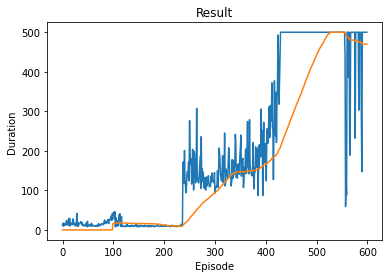

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [12]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 50
    
for i_episode in range(num_episodes):
    if gym.__version__[:4] == '0.26':
        state, _ = env.reset()
    elif gym.__version__[:4] == '0.25':
        state, _ = env.reset(return_info=True)
    
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated
        
        if terminated:
            next_state = None
        else:
            next_state =  torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
            
        memory.push(state, action, next_state, reward)
        
        state = next_state
        optimize_model()
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()        
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        
        target_net.load_state_dict(target_net_state_dict)
        
        if done:
            episode_durations.append(t+1)
            plot_durations()
            break
        
print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()


## Saving/Loading the trained model

In [13]:
torch.save(policy_net.state_dict(), './dicts/pol.pth')

In [21]:
state, _ = env.reset()
n_observations = len(state)
n_actions = env.action_space.n
policy_net = DQN(n_observations, n_actions).to(device)

In [22]:
policy_net.load_state_dict(torch.load('./dicts/pol.pth'))
policy_net.eval()

DQN(
  (layer1): Linear(in_features=4, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=2, bias=True)
)

## Running the trained policy, and saving a video of the result

In [23]:
def select_action(state):
    return policy_net(state).max(0)[1]

In [24]:
from gym.utils.save_video import save_video
env = gym.make("CartPole-v1", render_mode="rgb_array_list")
observation, info = env.reset(seed=42)
observation = torch.tensor(observation, dtype=torch.float32, device=device)

step_starting_index = 0
episode_index = 0
for step in range(1000):
    action = select_action(observation)  # User-defined policy function
    observation, reward, terminated, truncated, info = env.step(action.item())
    observation = torch.tensor(observation, dtype=torch.float32, device=device)
    
    if terminated or truncated:
        save_video(
         env.render(),
         "videos",
         fps=env.metadata["render_fps"]
        )
#         step_starting_index = step_index + 1
#         episode_index += 1
# #         env.reset()
        break
env.close()

Moviepy - Building video G:\Github Models\videos/rl-video-episode-0.mp4.
Moviepy - Writing video G:\Github Models\videos/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready G:\Github Models\videos/rl-video-episode-0.mp4
